Notebook for full ball detection using methods

https://towardsdatascience.com/inverse-projection-transformation-c866ccedef1c

In [2]:
# import stuff
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split

import ImageMethods
import DataMethods
import BallTrackingMethods

from imp import reload

Using TensorFlow backend.


In [3]:
reload(ImageMethods)
reload(DataMethods)
reload(BallTrackingMethods)

<module 'BallTrackingMethods' from '/Users/Moishe/JupyterProjects/TennisBallDetection/BallTrackingMethods.py'>

In [4]:
def meanClusterFlow(flow, labels, label_num):
    idx_cluster = (labels==label_num)
    cluster = flow[idx_cluster]
    mean = np.mean(cluster,axis=0)
    return mean

In [5]:
def maxClusterFlow(flow, labels, label_num):
    idx_cluster = (labels==label_num)
    cluster = flow[idx_cluster]
#     find greatest absolute flow in each direction
    max_x = cluster[np.argmax(np.abs(cluster[:,0])),0]
    max_y = cluster[np.argmax(np.abs(cluster[:,1])),1]
    return max_x, max_y

In [6]:
# load video, frame
# load model

In [7]:
place = "SBCC"
num = "4"

In [8]:
model = BallTrackingMethods.createModel()
model.load_weights("./model/weights")

In [9]:
# find possible clusters with method in frame
# use model to determine whether cluster is ball
# find flow for frame/ball area
# keep track of flow (and pos of ball)
# determine when flow changes drastically 

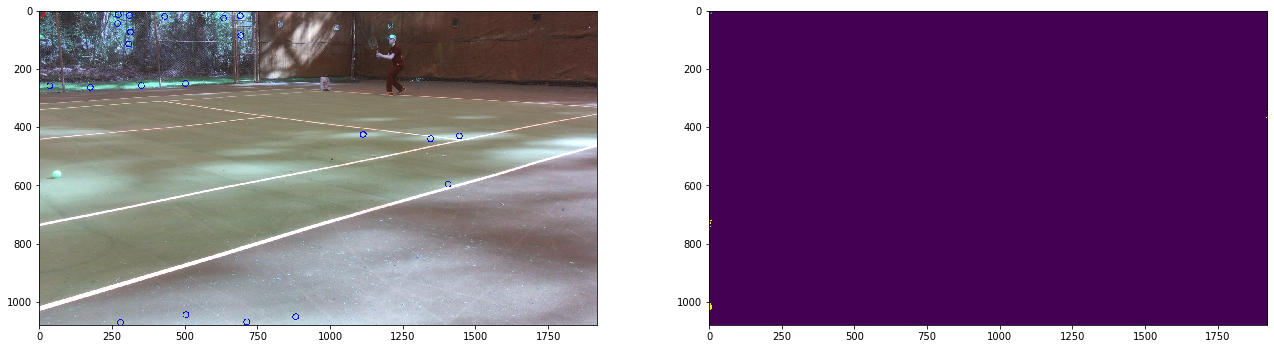

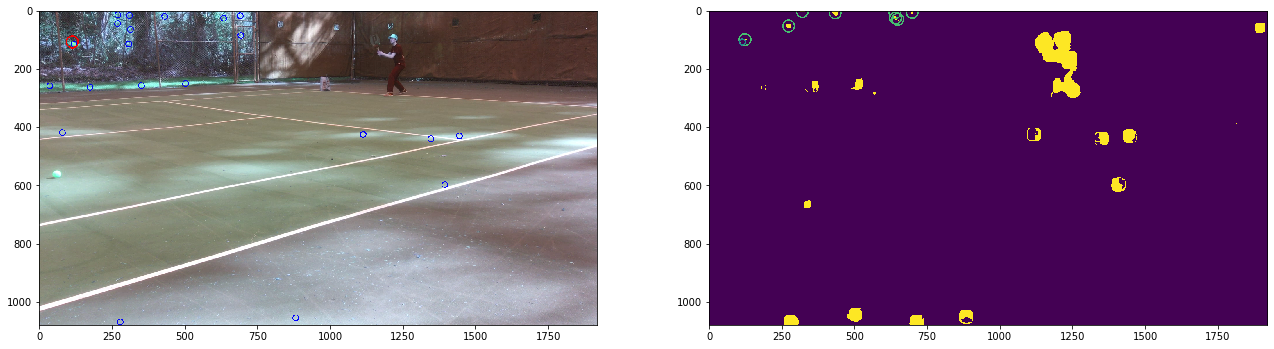

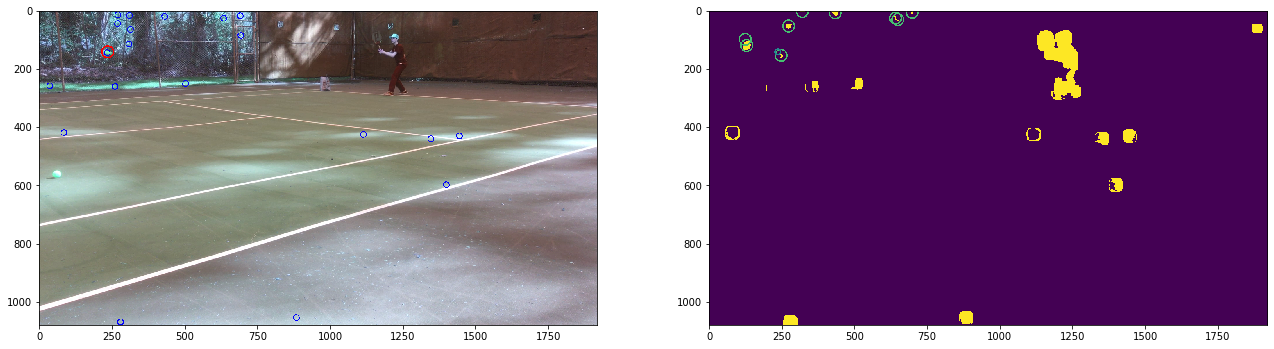

In [12]:
model_img_size = 32

cap, frame_count = DataMethods.loadVidCap(place, num)
ball_centers = DataMethods.loadBallCenters(place, num)

for i in range(3):
    
    ret, frame = cap.read()
    if i == 0:
        prev_frame = frame.copy()
        
#     GET CURRENT BALL CENTERS
    true_x, true_y = (0,0)
    cur_ball_centers = ball_centers[(ball_centers[:, 0] == i)]
    for ball_center in cur_ball_centers:
        true_x = int(ball_center[1])
        true_y = int(ball_center[2])
    
#     ML MODEL APPLIED TO IMAGE
    frame_16 = cv.pyrDown(cv.pyrDown(frame))
    row_samples = int(frame_16.shape[0]/model_img_size)-1
    col_samples = int(frame_16.shape[1]/model_img_size)-1
    predictions = np.zeros((row_samples, col_samples))
    for row in range(row_samples):
        for col in range(col_samples):
            frame_sample = frame_16[row*model_img_size : (row+1)*model_img_size, col*model_img_size : (col+1)*model_img_size]            
            prediction = model.predict(np.reshape(frame_sample, (1,model_img_size,model_img_size,3)))
            if prediction[0,0] > 0.5:
                predictions[row,col] = 1
#                 plt.figure()
#                 plt.imshow(frame_sample)

#     FLOW CLUSTERING
    flow_bgr, flow_gray, flow_thresh, flow, (label_num, labels, stats, centroids) = BallTrackingMethods.thresholdFlowBallClusters(prev_frame, frame, flow_threshold=30, a_min=5)
    for cmp in range(label_num.shape[0]):
        cen_x = int(centroids[cmp,0])
        cen_y = int(centroids[cmp,1])
        s=96
        
#         frame sample is a 32 x 32 sample from the center of the component (doesnt work well)
        if cen_x>16 and cen_y>16 and False:
            frame_sample = frame[cen_y-16:cen_y+16, cen_x-16:cen_x+16]
#         frame sample represents the flow component in size
        elif cen_x>s and cen_x<1920-s and cen_y>s and cen_y<1080-s:
            corner_x = int(cen_x-s/2)
            corner_y = int(cen_y-s/2)
            for num in range(2 , 4 + 1):
                for x_num in range(num):
                    for y_num in range(num):
                        width = int(s/num)
                        top = corner_y+width*y_num
                        bottom = corner_y+width*(y_num+1)
                        left = corner_x+width*x_num
                        right = corner_x+width*(x_num+1)
                        frame_sample = frame[top:bottom, left:right]
                        frame_sample = cv.resize(frame_sample, (model_img_size,model_img_size))
                        prediction = model.predict(np.reshape(frame_sample, (1,model_img_size,model_img_size,3)))
                        if prediction[0,0] > 0.5 and ((left-true_x)**2 + (top-true_y)**2 < 10000):
                            pass
#                             plt.figure()
#                             plt.imshow(frame_sample)
        else:
            top = stats[cmp,cv.CC_STAT_TOP]
            bottom = top + stats[cmp, cv.CC_STAT_HEIGHT]
            left = stats[cmp, cv.CC_STAT_LEFT]
            right = left + stats[cmp, cv.CC_STAT_WIDTH]
            frame_sample= frame[top:bottom, left:right]
            frame_sample = cv.resize(frame_sample, (model_img_size,model_img_size))
#         disply if the components should represent the ball
#         if ((cen_x-true_x)**2 + (cen_y-true_y)**2 < 2500):
#             plt.figure()
#             plt.imshow(frame_sample)
#             print(bottom-top, right-left)
        

        prediction = model.predict(np.reshape(frame_sample, (1,model_img_size,model_img_size,3)))
        if prediction[0,0] > 0.5:
            x,y = centroids[cmp].astype(int)
            cv.circle(flow_bgr, (x,y), 20, (0,255,0),3)
            cv.circle(flow_thresh, (x,y), 20, (180),3)
            fx, fy = meanClusterFlow(flow, labels, cmp)
            cv.line(flow_bgr, (x,y), (x+int(fx*50), y+int(fy*50)), (255,255,0),3)
#             plt.figure()
#             plt.imshow(cv.cvtColor(frame_sample, cv.COLOR_BGR2RGB))

        
#     HSV CLUSTERING
    frame_open, label_num, labels, stats, centroids = BallTrackingMethods.thresholdHSVBallClusters(frame, a_min = 300, a_max=10000)
    for center in centroids:
        cv.circle(frame, (int(center[0]), int(center[1])), 10, (0,0,255), 2)   
    
#     SHOW GROUND TRUTH BALLS
    cv.circle(frame, (true_x,true_y), 20, (255, 0, 0), 3)
    cv.circle(flow_thresh, (true_x,true_y), 10, 120, 3)
    cv.circle(flow_bgr, (true_x,true_y), 30, (255,0,0),3)
    
    prev_ball_centers = ball_centers[(ball_centers[:, 0] == i-1)]
    for ball_center in prev_ball_centers:
        x = int(ball_center[1])
        y = int(ball_center[2])
        cv.circle(flow_bgr, (x,y), 20, (255,0,0),3)
        
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(22,8)
    ax1.imshow(frame)
    ax2.imshow(flow_thresh)
    
    prev_frame = frame.copy()
    

In [218]:
print(range(2,5))

range(2, 5)


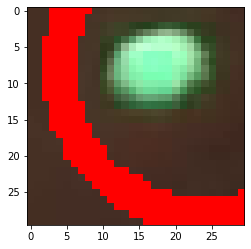

In [209]:
plt.imshow(frame[170:200,1020:1050])
# 

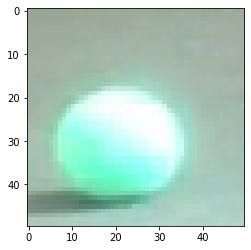

In [210]:
plt.imshow(frame[530:580, 40:90])

In [ ]:
average: 60